In [124]:
import os
import random
import numpy as np
import scipy.io
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, roc_curve, auc, classification_report
from sklearn.utils import shuffle
from sklearn.neural_network import MLPClassifier
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
from read_eeg import get_eeg_info
from scipy.signal import welch

In [126]:
def read_egg(path):
    mat = scipy.io.loadmat(path)
    eeg = mat['transferred_EEG']['trial'][0,0][0,0]  # first trial
    return eeg

In [127]:
# --- Parameters ---
healthy_folder = 'C:/Users/Haiya/Downloads/Data_EEG/Data_EEG/Healthy/'
ad_folder = 'C:/Users/Haiya/Downloads/Data_EEG/Data_EEG/AD/'

fs = 500
min_samples = int(0.5 * 60 * fs)
max_samples = int(1.0 * 60 * fs)
num_segments = 50 # extract 50 segments from each sample!

# --- File Loading ---
ad_files = [f for f in os.listdir(ad_folder)]
healthy_files = [f for f in os.listdir(healthy_folder)]

random.seed(1)
random.shuffle(ad_files)
random.shuffle(healthy_files)

AD_data = {}
heal_data = {} 

for i in ad_files: 
    egg = read_egg(ad_folder + i)
    AD_data[i + '_AD'] = egg

for i in healthy_files: 
    egg = read_egg(healthy_folder + i)
    heal_data[i+ '_healthy'] = egg

In [128]:
def split_dict_with_sklearn(data_dict, seed=42):
    keys = list(data_dict.keys())

    # First: split into train (80%) and temp (20%)
    train_keys, temp_keys = train_test_split(keys, test_size=0.4, random_state=seed)

    # Second: split temp into val (10%) and test (10%)
    val_keys, test_keys = train_test_split(temp_keys, test_size=0.5, random_state=seed)

    # Reconstruct dictionaries
    train = {k: data_dict[k] for k in train_keys}
    val   = {k: data_dict[k] for k in val_keys}
    test  = {k: data_dict[k] for k in test_keys}
    return train, val, test

In [130]:
# Apply to each class
ad_train, ad_val, ad_test = split_dict_with_sklearn(AD_data)
hl_train, hl_val, hl_test = split_dict_with_sklearn(heal_data)

# Combine class-wise splits
train_rd = {**ad_train, **hl_train}
val_rd   = {**ad_val, **hl_val}
test_rd  = {**ad_test, **hl_test}

print(f"Train size: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

Train size: 900, Val: 300, Test: 350


In [134]:
# --- Helper Functions ---
def segment_subjects(data_dict, num_segments, min_len, max_len):
    segments = []
    labels = []
    for k, eeg in data_dict.items():
        total_samples = eeg.shape[1]
        for _ in range(num_segments):
            length = random.randint(min_len, max_len)
            start = random.randint(0, total_samples - length)
            segment = eeg[:, start:start+length]
            segments.append(segment)
            labels.append(1 if '_AD' in k else 0)
    return segments, labels

bands = {'Delta': (1, 4), 'Theta': (4, 8), 'Alpha': (8, 13), 'Beta': (13, 30), 'Gamma': (30, 70)}

def extract_features(eeg_data, fs):
    features = []
    for seg in eeg_data:
        ch_features = []
        for ch in seg:
            f, pxx = welch(ch, fs=fs, window='hamming', nperseg=512, noverlap=256, nfft=512)
            total_power = np.trapz(pxx[(f >= 0.5) & (f <= 70)], f[(f >= 0.5) & (f <= 70)])
            p_norm = pxx / np.sum(pxx)

            band_feats = []
            for band, (low, high) in bands.items():
                band_power = np.trapz(pxx[(f >= low) & (f <= high)], f[(f >= low) & (f <= high)])
                band_feats.append(band_power / total_power)

            entropy = -np.sum(p_norm * np.log2(p_norm + np.finfo(float).eps))
            mean_freq = np.sum(f * pxx) / np.sum(pxx)
            theta_alpha = band_feats[1] / (band_feats[2] + np.finfo(float).eps)
            delta_alpha = band_feats[0] / (band_feats[2] + np.finfo(float).eps)

            ch_features.append(band_feats + [entropy, mean_freq, theta_alpha, delta_alpha])

        features.append(np.array(ch_features).flatten())
    return np.array(features)

In [136]:
# --- Process Data ---
train_data, train_labels = segment_subjects(train_rd, num_segments, min_samples, max_samples)
val_data, val_labels = segment_subjects(val_rd, num_segments, min_samples, max_samples)
test_data, test_labels = segment_subjects(test_rd, num_segments, min_samples, max_samples)

# Balance train set
train_data, train_labels = shuffle(train_data, train_labels, random_state=1)
ad_idx = [i for i, l in enumerate(train_labels) if l == 1]
hl_idx = [i for i, l in enumerate(train_labels) if l == 0]
min_class = min(len(ad_idx), len(hl_idx))
sel_idx = ad_idx[:min_class] + hl_idx[:min_class]
train_data = [train_data[i] for i in sel_idx]
train_labels = [train_labels[i] for i in sel_idx]

# Feature extraction
train_features = extract_features(train_data, fs)
val_features = extract_features(val_data, fs)
test_features = extract_features(test_data, fs)

In [140]:
train_features.shape

(900, 171)

In [142]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)
val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

# --- Train Model ---
model = MLPClassifier(hidden_layer_sizes=(64, 32, 16, 8, 4), alpha=0.015, learning_rate_init= 2e-4,
                     max_iter=500, batch_size=32, early_stopping=True, random_state=1)
model.fit(train_features, train_labels)

MLPClassifier(alpha=0.015, batch_size=32, early_stopping=True,
              hidden_layer_sizes=(64, 32, 16, 8, 4), learning_rate_init=0.0002,
              max_iter=500, random_state=1)

Test Accuracy: 72.29%


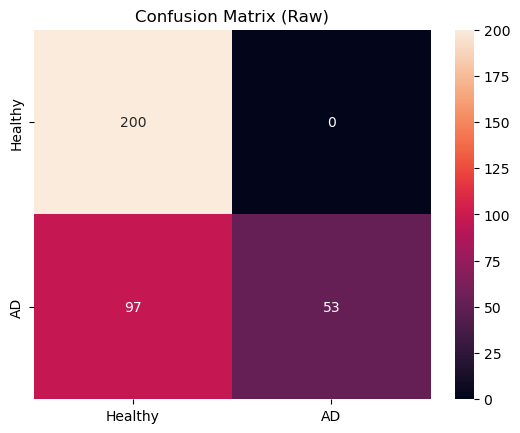

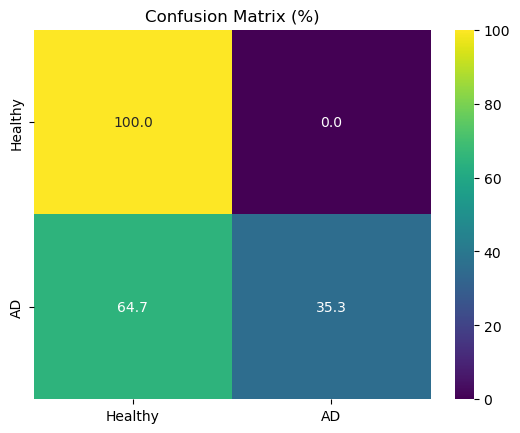

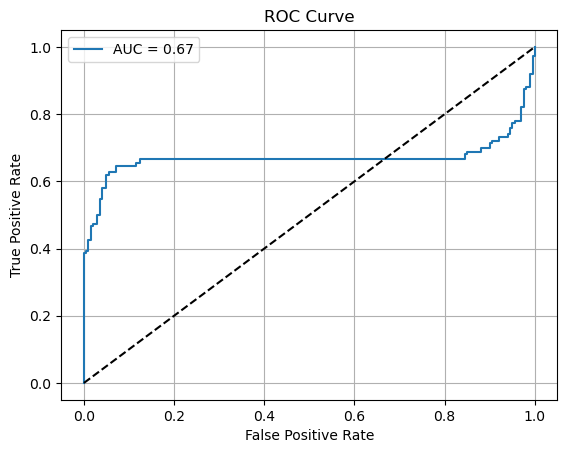

              precision    recall  f1-score   support

     Healthy       0.67      1.00      0.80       200
          AD       1.00      0.35      0.52       150

    accuracy                           0.72       350
   macro avg       0.84      0.68      0.66       350
weighted avg       0.81      0.72      0.68       350

Visualizing features with PCA and t-SNE...


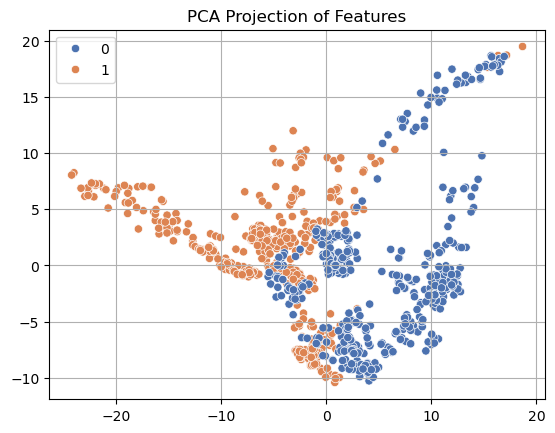

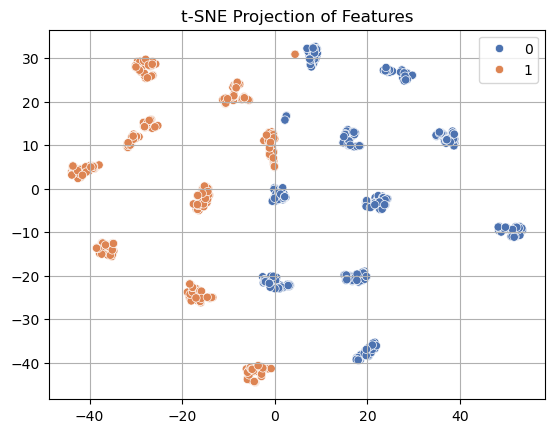

In [144]:
# --- Evaluation ---
predicted_labels = model.predict(test_features)
accuracy = np.mean(predicted_labels == test_labels) * 100
print(f"Test Accuracy: {accuracy:.2f}%")

C = confusion_matrix(test_labels, predicted_labels)
sns.heatmap(C, annot=True, fmt='d', xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.title("Confusion Matrix (Raw)")
plt.show()

C_percent = 100 * C / C.sum(axis=1, keepdims=True)
sns.heatmap(C_percent, annot=True, fmt='.1f', cmap='viridis', xticklabels=['Healthy', 'AD'], yticklabels=['Healthy', 'AD'])
plt.title("Confusion Matrix (%)")
plt.show()

# --- ROC Curve ---
scores = model.predict_proba(test_features)[:,1]
fpr, tpr, _ = roc_curve(test_labels, scores)
roc_auc = auc(fpr, tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate')
plt.title('ROC Curve'); plt.legend(); plt.grid(True)
plt.show()

# --- Additional Metrics ---
print(classification_report(test_labels, predicted_labels, target_names=['Healthy', 'AD']))

# --- PCA and t-SNE Visualization ---
print("Visualizing features with PCA and t-SNE...")
pca = PCA(n_components=2)
pca_proj = pca.fit_transform(train_features)
plt.figure()
sns.scatterplot(x=pca_proj[:,0], y=pca_proj[:,1], hue=train_labels, palette='deep')
plt.title('PCA Projection of Features')
plt.grid(True)
plt.show()

tsne_proj = TSNE(n_components=2, perplexity=30, random_state=1).fit_transform(train_features)
plt.figure()
sns.scatterplot(x=tsne_proj[:,0], y=tsne_proj[:,1], hue=train_labels, palette='deep')
plt.title('t-SNE Projection of Features')
plt.grid(True)
plt.show()